# Book Genre Prediction Model

### This model was created to predict a book's genre by it's desciption. 




First - importing all The necessary Libraries.

In [1]:
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from langdetect import detect_langs

from typing import Any, Dict, List

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from scipy.stats import randint

from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)

import cloudpickle
import eli5
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

Please un-comment and run the below if you do not have any of these downloaded yet.

In [ ]:
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download('omw-1.4')
# nltk.download('words')

## Data Audit

The data was scraped by me, from the website 'bookshop.org'. I'll be working with books from 5 different genres: 'Philosophers', 'Cooking', 'History', 'Biblical' and 'Romance'

In [10]:
# Needs updated files

Philosophers = pd.read_csv('.data/Philosophers.csv', sep=',', index_col=0)
Cooking = pd.read_csv('.data/Cooking.csv', sep=',', index_col=0)
History = pd.read_csv('.data/History.csv', sep=',', index_col=0)
Biblical = pd.read_csv('.data/Biblical_Studies.csv', sep=',', index_col=0)
Romance = pd.read_csv('.data/Romance.csv', sep=',', index_col=0)

combined_df = pd.concat([Philosophers, Cooking, History, Biblical, Romance], ignore_index=True,axis=0)

In [ ]:
# PUT DF INTO A DB TABLE

A peek into the combined dataset:

In [11]:
combined_df.head()

,title,about,genre
0,Meditations: A New Translation (Revised),\nDescription\nNearly two thousand years after...,Philosophers
1,Meditations,\nDescription\nA leading translation of Stoic ...,Philosophers
2,How to Think Like a Roman Emperor: The Stoic P...,\nDescription\nThis is a wonderful and importa...,Philosophers
3,Heartbreak: A Personal and Scientific Journey,\nDescription\nWhen her twenty-five-year marri...,Philosophers
4,Walden,\nDescription\nDesigned to appeal to the book ...,Philosophers


I can see the 'about' column is literred with unneccessary symbols. Let's write a function to clean the text. Later, for machine learning, I'll write a separate TextTransformer, so in the modelling part I'll be using the raw desriptions. However, to make sure we remove all the duplicates, we need to have the 'cleaned' columns here as well.

In [12]:
def preprocess_text(text):
    string = re.sub(r'\ndescription\n', ' ', str(text).lower())
    string = re.sub(r'\*|\-|\[|\]|\"', ' ', string)
    string = re.sub(r'[^a-zA-Z]', ' ', string)
    string = re.sub(r'(?:^| )\w(?:$| )', ' ', string)
    string = re.sub(r'\s+', ' ', string).strip()
    return string

I will be removing duplicates based on 'title' and 'about', so both columns will get cleaned.

In [13]:
combined_df_2 = combined_df.copy()

combined_df_2['title_cleaned'] = combined_df_2['title'].apply(preprocess_text)
combined_df_2['about_cleaned'] = combined_df_2['about'].apply(preprocess_text)

In [14]:
combined_df_2[['title_cleaned', 'about_cleaned', 'genre']].describe()

,title_cleaned,about_cleaned,genre
count,458,458,458
unique,456,456,5
top,the transcendentalists and their world,no source other than the bible itself provides...,Romance
freq,2,2,100


From the above, there seems to be a few duplicates. Let's look at their values

In [15]:
duplicateRows = combined_df_2[combined_df_2.duplicated(['title_cleaned'])]
print(duplicateRows.title.values)

duplicateRows = combined_df_2[combined_df_2.duplicated(['about_cleaned'])]
print(f"\n{duplicateRows.about_cleaned.values}")

['The Transcendentalists and Their World'
 'An Enquiry Concerning Human Understanding']

['an enquiry concerning human understanding is book by the scottish empiricist philosopher david hume published in english in it was revision of an earlier effort hume a treatise of human nature published anonymously in london in hume was disappointed with the reception of the treatise which fell dead born from the press as he put it and so tried again to disseminate his more developed ideas to the public by writing shorter and more polemical work the end product of his labours was the enquiry the enquiry dispensed with much of the material from the treatise in favor of clarifying and emphasizing its most important aspects for example hume views on personal identity do not appear however more vital propositions such as hume argument for the role of habit in theory of knowledge are retained this book has proven highly influential both in the years that would immediately follow and today immanuel kan

Dropping the duplicates

In [16]:
combined_df_2 = combined_df_2.drop_duplicates(["title_cleaned"])
combined_df_2 = combined_df_2.drop_duplicates(["about_cleaned"])
combined_df_2[['title_cleaned', 'about_cleaned', 'genre']].describe()

,title_cleaned,about_cleaned,genre
count,455,455,455
unique,455,455,5
top,meditations new translation revised,nearly two thousand years after it was written...,Romance
freq,1,1,100


Now that there are no more duplicates, let's see if there are any empty values

In [17]:
combined_df_2.isnull().sum()

title            0
about            0
genre            0
title_cleaned    0
about_cleaned    0
dtype: int64

There are no NULL values in any of the fields. That's good.

The data was scraped from and english website, but just in case I'll check if there are any non-english descriptions. For this purpose, I'll use the 'langdetect' package. 'detect_langs' allows to find out the probabilities for the top languages detected in a piece of text. More about the package here: https://pypi.org/project/langdetect/

In [18]:
combined_df_2['languages'] = combined_df['about'].apply(detect_langs)

Let's check if there are any descriptions that have probabilities for more than one language

In [19]:
combined_df_2['languages_count'] = combined_df_2.languages.apply(lambda x: len(str(x).split(',')))
combined_df_2[['title', 'genre', 'languages', 'languages_count']][combined_df_2['languages_count']>1]

,title,genre,languages,languages_count
291,Los Primeros Cristianos: Un Recuento Bíblico E...,Biblical,"[es:0.7142831796994447, en:0.28571501975456315]",2
322,El Tabernáculo: Guía Ilustrada = The Tabernacle,Biblical,"[es:0.5714298039751264, en:0.42856895604988754]",2
353,La Belleza de la Cruz - Estudio Bíblico: Conte...,Biblical,"[en:0.7142854453389176, es:0.2857127867194136]",2
357,Guía Esencial de la Biblia: Un Recorrido Compl...,Biblical,"[es:0.5714273029080186, en:0.4285708436114256]",2


There are 4 such descriptions. Let's look at their values.

In [20]:
for value in combined_df_2.loc[combined_df_2["languages_count"] == 2].about_cleaned.values:
    print(value)
    print()

continuando su obra biogr fica el autor dr sar vidal nos invita explorar la pregunta mo luc el cristianismo en la iglesia primitiva esta pregunta ha sido abordada con mucho escepticismo lo largo de los os ya que muchos han argumentado que los recuentos de la iglesia primitiva son en el mejor de los casos ficci con estilo elocuente persuasivo sar vidal ser tu gu a trav de datos blicos fuentes confiables para demostrar la certeza car cter del testimonio de aquellos que conocieron personalmente jes the first christians continuing his biographical work the author dr sar vidal invites us to explore the question what was christianity like in the early church this question has been met by much skepticism over the years for many have argued that the accounts of the early church are at best fictional in his eloquent and persuasive style sar vidal will serve as tour guide through both biblical data and reliable sources to show the certainty and character of the eyewitness testimony of those who 

It's evident that they really do contain spanish. These records will be removed.

In [21]:
combined_df_2 = combined_df_2[combined_df_2["languages_count"]==1]

The final dataset looks like this: 

In [22]:
combined_df_2[['title', 'title_cleaned', 'about', 'about_cleaned', 'genre']].describe()

,title,title_cleaned,about,about_cleaned,genre
count,451,451,451,451,451
unique,451,451,451,451,5
top,Meditations: A New Translation (Revised),meditations new translation revised,\nDescription\nNearly two thousand years after...,nearly two thousand years after it was written...,Romance
freq,1,1,1,1,100


## EDA

First of, let's look how genre distribution looks

<BarContainer object of 5 artists>

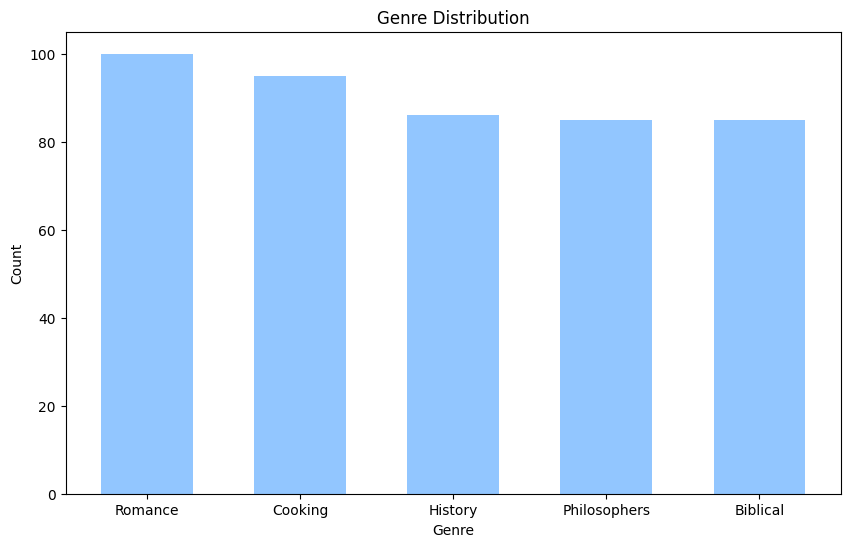

In [24]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca()
plt.style.use('seaborn-v0_8-pastel')
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Genre Distribution")
plt.bar(combined_df_2['genre'].value_counts().index, combined_df_2['genre'].value_counts().values, width=0.6)

It looks like there are the most of 'Romance' and 'Cooking' books scraped, other three genres have a lower count of records.

I wonder how long is the average description? Let's look at that below.

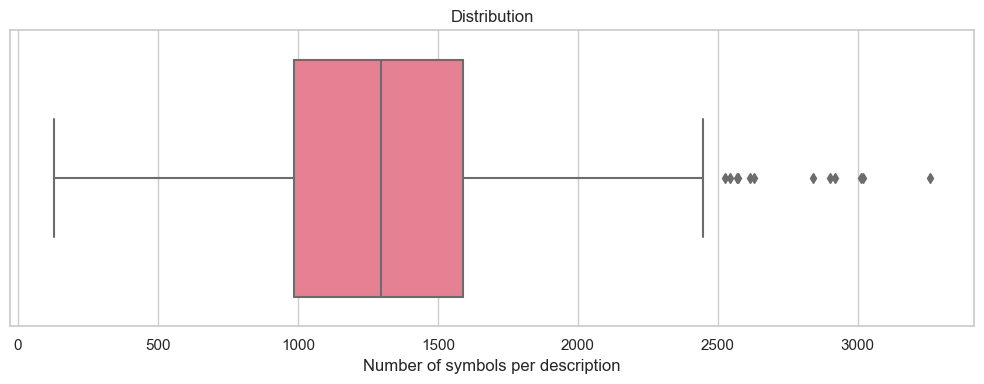

In [25]:
sns.set(style="whitegrid",rc={"font.size":12,"axes.labelsize":12})
plt.figure(figsize=(10, 4))

dataf = combined_df_2.copy()
dataf['len'] = combined_df_2['about_cleaned'].apply(lambda x: len(x))

ax = sns.boxplot(x='len', data=dataf, palette="husl")
plt.ylabel('')
plt.xlabel('Number of characters per description')
plt.title("Distribution", fontsize=12)
plt.tight_layout()

It's seems that the average book description contains around ~1,300 symbols, with most of them having between roughly a 1,000 and 1,600 symbols. However, there are some outliers: a few descriptions contains even more than 2,500 characters!

Let's take a look at the longest and shortest descriptions. 

Longest description:

In [38]:
print(dataf['len'][dataf['len']==dataf['len'].max()].values)
print(dataf['about_cleaned'][dataf['len']==dataf['len'].max()].values)

[3259]
['the culinary revolution that has transformed restaurant menus around the world is also making its way into home kitchens the cooking lab publisher of the encyclopedic six volume set modernist cuisine which immediately became the definitive reference for this revolution has now produced lavishly illustrated guide for home cooks complete with all new recipes tailored for cooking enthusiasts of all skill levels modernist cuisine at home by nathan myhrvold with maxime bilet is destined to set new standard for home cookbooks the authors have collected in this page volume all the essential information that any cook needs to stock modern kitchen to master modernist techniques and to make hundreds of stunning recipes the book includes spiral bound kitchen manual that reprints all of the recipes and reference tables on waterproof tear resistant paper drawing on the same commitment to perfection that produced modernist cuisine modernist cuisine at home applies innovations pioneered by t

Shortest description:

In [39]:
print(dataf['len'][dataf['len']==dataf['len'].min()].values)
print(dataf['about_cleaned'][dataf['len']==dataf['len'].min()].values)

[128]
['suppressed by the early church fathers who compiled the bible these apocryphal books have for centuries been shrouded in silence']


Both descriptions seem to be proper narratives on the books, so all good.

Now let's take a look at descriptions' lengths word-wise. A plot representing the relationship by genre is displayed below:

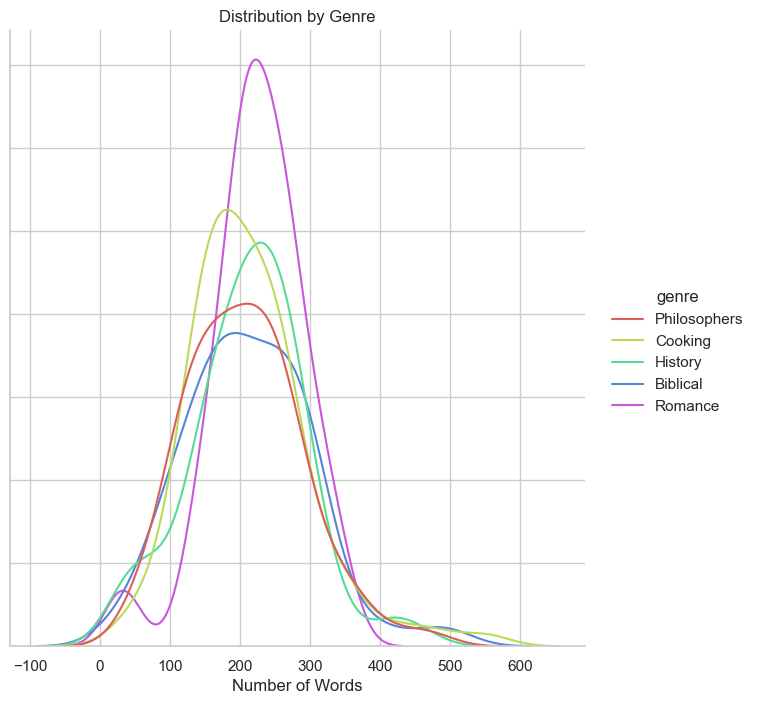

In [40]:
df2 = combined_df_2.copy()
df2['about_length'] = df2['about_cleaned'].str.split().str.len()

g1 = sns.displot(data=df2,x="about_length",hue="genre",kind="kde",height=7,palette="hls")
g1.set(yticklabels=[])
g1.set(ylabel=None)
g1.set(xlabel='Number of Words')
g1.set(title='Distribution by Genre')

The distributions are not that different depending on the genre. Most descriptions are between 200 and 300 word long. However, I can see there is a spike of short descriptions for Romance books.

Now, let's focus on single word count by the genre. Since we will be using descriptions to predict the genre, it's useful to look at what words are the most prominent for which genres. For this calculation, I'll be excluding english stop words so they would not skew the results.

In [41]:
stops=set(stopwords.words('english'))


def word_count(genre, df):
    all_wrds=[]
    for x in df[df['genre']==genre]['about_cleaned'].str.split():
        for i in x:
            all_wrds.append(i.lower())
    return all_wrds


def count_by_genre(genre, df):
    all_wrds=word_count(genre, df)
    counter=Counter(all_wrds)
    most=counter.most_common()
    
    result: List[Dict] = []
    for word,count in most[:]:
        if (word.lower() not in stops):
            result.append({
                "word": word.lower(), 
                "count": count
        })
    result = pd.DataFrame(result)
    return result


history=count_by_genre('History', combined_df_2)
philosophers=count_by_genre('Philosophers', combined_df_2)
cooking=count_by_genre('Cooking', combined_df_2)
romance=count_by_genre('Romance', combined_df_2)
biblical=count_by_genre('Biblical', combined_df_2)

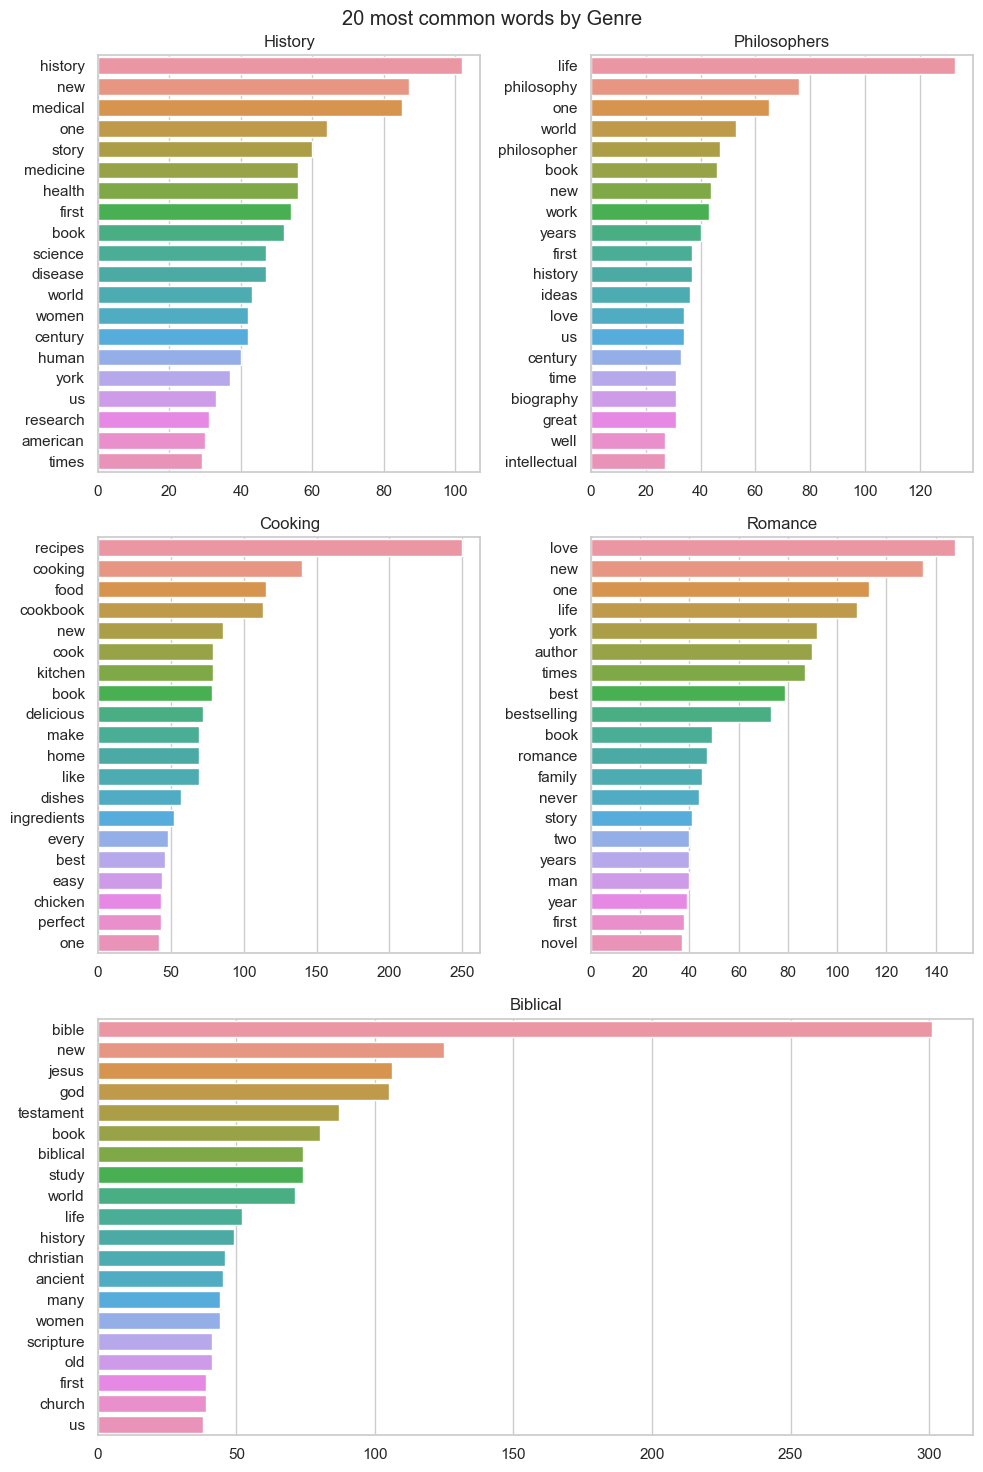

In [42]:
fig = plt.figure(figsize=(10, 15)) 

fig.suptitle('20 most common words by Genre')

a1 = plt.subplot2grid((3, 2), (0, 0), colspan=1)
a2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
a3 = plt.subplot2grid((3, 2), (1, 0), colspan=1)
a4 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
a5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

plot1 = sns.barplot(x=history['count'][0:20].values.tolist(),y=history['word'][0:20].values.tolist(),ax=a1).set_title('History')
plot2 = sns.barplot(x=philosophers['count'][0:20].values.tolist(),y=philosophers['word'][0:20].values.tolist(),ax=a2).set_title('Philosophers')
plot3 = sns.barplot(x=cooking['count'][0:20].values.tolist(),y=cooking['word'][0:20].values.tolist(),ax=a3).set_title('Cooking') 
plot4 = sns.barplot(x=romance['count'][0:20].values.tolist(),y=romance['word'][0:20].values.tolist(),ax=a4).set_title('Romance') 
plot5 = sns.barplot(x=biblical['count'][0:20].values.tolist(),y=biblical['word'][0:20].values.tolist(),ax=a5).set_title('Biblical')

plt.tight_layout()
plt.show()

The plot above allows us to see that all of the genres have their stems in top 20 words, most being in the top 5. Romance is the only exception - the word 'romance' is 11th. From this, it is clear that the words that have the same stems as the genres will have top be removed from the descriptions when modelling. The plot also showcases how some words are not genre specific and are littering the descriptions, e.g.: new, york, one, author, bestselling, etc. These have to be removed as well. Using the information we were able to see from the above, let's add these 'additional stopwords' into a list:

In [43]:
additional_stopwords = ['new', 'york', 'times', 'bestseller', 'bestselling', 'editors', 'choice', 'award', 'awards', 'author', 'book', 'best', 'will', 'today', 'first', 
'one', 'history', 'philosophical', 'philosophy', 'philosopher', 'philosophers', 'cooking', 'cookbook', 'cook', 'romance', 'bible', 'biblical', 'historical']

f = lambda x: ' '.join([i for i in x.split() if i.lower() not in additional_stopwords])
combined_df_2["about_cleaned_2"] = combined_df_2["about_cleaned"].copy().apply(f)

Now, that the additional stopwords have been identified and removed from the description, let's look at the wordclouds by genre to see if they look more representative to the genre.

First is 'History' -- main words seem to be medical, medicine, science, human, disease, story, women, world, etc.

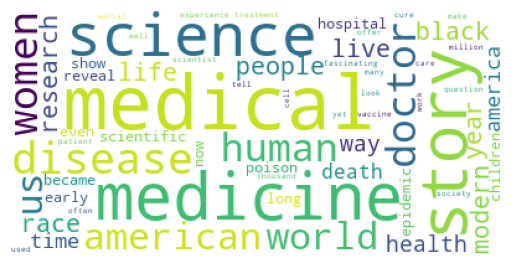

In [44]:
history_descriptions = combined_df_2.loc[combined_df_2["genre"] == "History"]["about_cleaned_2"].values
wordcloud = WordCloud(background_color="white",max_words=60,max_font_size=60, relative_scaling=.5).generate(str(history_descriptions))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Second is 'Philosophers' -- main words seem to be life, world, work, year, love (which I am guessing will be very prominent in Romance) and intellectual

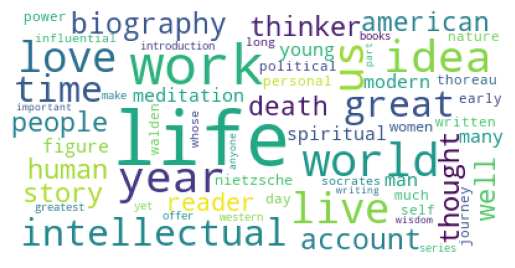

In [45]:
philosophers_descriptions = combined_df_2.loc[combined_df_2["genre"] == "Philosophers"]["about_cleaned_2"].values
wordcloud = WordCloud(background_color="white",max_words=60,max_font_size=60, relative_scaling=.5).generate(str(philosophers_descriptions))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Third is 'Cooking' -- main words seem to be recipe, food, kitchen, delicious, ingredient, home, flavor, etc.

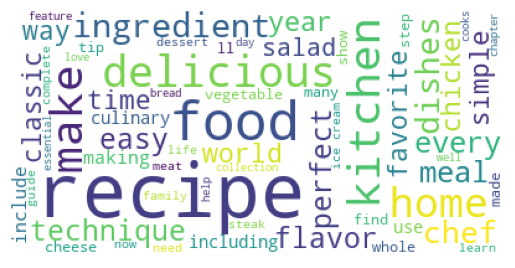

In [46]:
cooking_descriptions = combined_df_2.loc[combined_df_2["genre"] == "Cooking"]["about_cleaned_2"].values
wordcloud = WordCloud(background_color="white",max_words=60,max_font_size=60, relative_scaling=.5).generate(str(cooking_descriptions))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Fouth is 'Romance' -- main words seem to be love, world (both of which were prominent in 'Philosophers' category), life, year, never, find, family, man, etc.

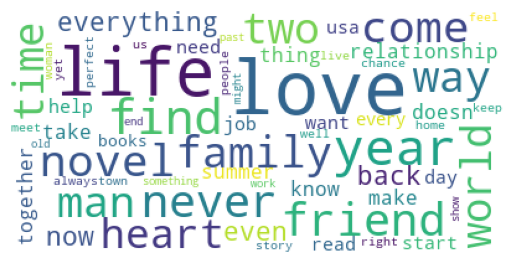

In [47]:
romance_descriptions = combined_df_2.loc[combined_df_2["genre"] == "Romance"]["about_cleaned_2"].values
wordcloud = WordCloud(background_color="white",max_words=60,max_font_size=60, relative_scaling=.5).generate(str(romance_descriptions))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Fifth is 'Biblical' -- main words seem to be jesus, god, study, world (yet again) christian, testament, scripture

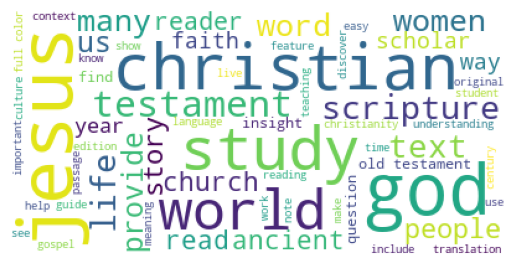

In [48]:
biblical_descriptions = combined_df_2.loc[combined_df_2["genre"] == "Biblical"]["about_cleaned_2"].values
wordcloud = WordCloud(background_color="white",max_words=60,max_font_size=60, relative_scaling=.5).generate(str(biblical_descriptions))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Some Inference from the Explanatory Data Analysis part:
* Albeit the dataset seems to be balanced, it's very small. Later on, I'll use stratified sampling when spliting the data into train and test DFs
* Average description contains somewhere around 1-1,6k symbols
* Average description contains somewhere around 200-300 words
* The dataset contains some redundant words - these will be removed as 'additional stopwords'


# Modelling

Let's prepare a DF that will be used for modelling

In [49]:
df = combined_df_2[['about', 'about_cleaned', 'genre']].copy()
df.rename(columns = {'genre':'label'}, inplace = True)

### Baseline Model

First step in the Modelling bit will be to create a Baseline model. A baseline model is a simple model that acts as a reference point in a ML project. Its main function is to contextualize the results of trained models. Baseline models usually lack complexity and may have little predictive power.

As noted in the previous (EDA) part, when analysing most common words by description, it was evident that each genre's one of the most common words was the one having it's stem in it -- e.g. philosophy, philosopher for the genre 'Philosophers'. Following this thought process, the logic for Baseline model will be:
* The 'genre' of the book will be determined by how many stems of a certain genre the record has in its' description. E.g. If it contains 2 words with stem for 'Philosophers', but 3 words for 'History', the genre will be 'History'. The records that will have the same amout of max stems or will not trigger any of the genre's stems will get a random prediction.

Function to count the number of a ceratin stem is present in the description:

In [50]:
def no_of_stems(sentence, stem):
    sentence = " ".join([i for i in sentence.split() if stem in i.lower()])
    return len(sentence.split())

Here are the stems used: 
* History: 'histor'
* Philosophers: 'philosoph'
* Cooking: 'cook'
* Romance: 'roman' 
* Biblical: 'bibl'

In [52]:
df['histor']=df['about_cleaned'].apply(no_of_stems, stem='histor')
df['philosoph']=df['about_cleaned'].apply(no_of_stems, stem='philosoph')
df['cook']=df['about_cleaned'].apply(no_of_stems, stem='cook')
df['roman']=df['about_cleaned'].apply(no_of_stems, stem='roman')
df['bibl']=df['about_cleaned'].apply(no_of_stems, stem='bibl')

Let's see how many records do not have any stems in their description: 

In [53]:
filter1 = df['histor'] == 0
filter2 = df['philosoph'] == 0
filter3 = df['cook'] == 0
filter4 = df['roman'] == 0
filter5 = df['bibl'] == 0

df[filter1 & filter2 & filter3 & filter4 & filter5]

,about,about_cleaned,label,histor,philosoph,cook,roman,bibl
3,\nDescription\nWhen her twenty-five-year marri...,when her twenty five year marriage suddenly fa...,Philosophers,0,0,0,0,0
11,"\nDescription\n""[Beauvoir's] graciously writte...",beauvoir graciously written memoirs carry dist...,Philosophers,0,0,0,0,0
31,\nDescription\nWhen Thomas Edison began wiring...,when thomas edison began wiring new york city ...,Philosophers,0,0,0,0,0
32,\nDescription\nIntroducing Plato provides a cl...,introducing plato provides clear account of pl...,Philosophers,0,0,0,0,0
36,"\nDescription\nMeetings with Remarkable Men, G...",meetings with remarkable men gurdjieff autobio...,Philosophers,0,0,0,0,0
...,...,...,...,...,...,...,...,...
443,"\nDescription\nColleen Hoover, the #1 New York...",colleen hoover the new york times bestselling ...,Romance,0,0,0,0,0
444,\nDescription\n From #1 New York Times ...,from new york times bestselling author colleen...,Romance,0,0,0,0,0
448,\nDescription\nA WALL STREET JOURNAL BEST BOOK...,wall street journal best book of summer indies...,Romance,0,0,0,0,0
449,\nDescription\nA GOOD MORNING AMERICA BOOK CLU...,good morning america book club pick book of th...,Romance,0,0,0,0,0


We can see the number is quite high: 110, which is 24% of the whole dataset. 

Let's write the baseline predictor:

In [54]:
class BaselinePredictor:
    def __init__(self) -> None:
        self._genre = ""
    
    def predict(self, histor: int, philosoph: int, cook: int, roman: int, bibl: int) -> None:
        de: List[Dict] = []
        
        de.append({
        "History": histor,
        "Philosophers": philosoph, 
        "Cooking": cook,
        "Romance": roman,
        "Biblical": bibl 
        })

        dee=dict((key, val) for k in de for key, val in k.items())
        max_value = max(dee.values())
        max_keys = [k for k, v in dee.items() if v == max_value]
        self._genre=random.choice(max_keys)
        return self._genre


In [55]:
baseline = BaselinePredictor()

Let's try it out with some random values:

In [59]:
print(f"{baseline.predict(1, 0, 0, 0, 0)}\n")
print(f"{baseline.predict(1, 3, 0, 0, 0)}\n")
print(f"{baseline.predict(0, 0, 0, 0, 0)}\n")

History

Philosophers

History



### Let's split the dataset into tain and test sets

We'll use these to validate our baseline predictor as well as for futher ML modelling. As I mentioned before, because the dataset is quite small and not all genres have the same amount of books in the data, I'll be using stratified sampling, which is a method of obtaining a representative sample from a population.

In [61]:
train_df, test_df = train_test_split(df, random_state=14, stratify=df['label'])
y_true = test_df["label"].values


Let's check how the baseline works on test data:

In [65]:
predictions_base = test_df[['histor', 'philosoph', 'cook', 'roman', 'bibl']].apply(lambda x: baseline.predict(*x), axis=1)

print("Accuracy: ", accuracy_score(y_true, predictions_base))
print("f1_score: ", f1_score(y_true, predictions_base, average="weighted"))


Accuracy:  0.6991150442477876
f1_score:  0.7003013979735796


Each time I run the code cell above, the answer differs. This is in part due to small sample size as well as 24% of the population being totally randomly predicted. A better approach would be to do an average of both accuracy and f1 score statistics. Let's write a function for that.

In [66]:
def several_scores(n, function):
    holder = []
    name = preprocess_text(function).split()[1]
    if name == 'score': 
        print(f"f1 {name}")
    else:
        print(f"{name}")

    for i in range(n):
        predictions = test_df[['histor', 'philosoph', 'cook', 'roman', 'bibl']].apply(lambda x: baseline.predict(*x), axis=1)

        if name == 'score': 
            var = function(y_true, predictions, average="weighted")
        else:
            var = function(y_true, predictions)
            
        holder.append(var)
        print("Run ", i+1, f" ", var)

    mean = sum(holder) / n
    return mean

In [67]:
several_scores(10, f1_score)

f1 score
Run  1   0.676045324717891
Run  2   0.7252901808251899
Run  3   0.6397785685343492
Run  4   0.6852199696700328
Run  5   0.678459076571563
Run  6   0.6253304391745003
Run  7   0.6874665381267469
Run  8   0.6374448244689035
Run  9   0.6417598499919964
Run  10   0.6352040016965551


0.6631998773777729

In [68]:
several_scores(10, accuracy_score)

accuracy
Run  1   0.6283185840707964
Run  2   0.6902654867256637
Run  3   0.6991150442477876
Run  4   0.6548672566371682
Run  5   0.672566371681416
Run  6   0.672566371681416
Run  7   0.6548672566371682
Run  8   0.6637168141592921
Run  9   0.6637168141592921
Run  10   0.6460176991150443


0.6646017699115044

Average of F1 Score is 0.6600469262305927, average Accuracy is 0.6761061946902654. Let's keep these in mind.

### Machine Learning Models

First - a little bit of theory. 

For the model below, I will be using Stemming and Lemmatization:

Stemming and Lemmatization are algorithms that are used in Natural Language Processing (NLP) to normalize text and prepare words and documents for further processing in Machine Learning. In NLP,  for example, you may want to acknowledge the fact that the words “like” and “liked” are the same word in different tenses. The goal is then to reduce both words to a common word root, which is done by either Stemming or Lemmatization. That way, both words are treated similarly, otherwise “like” and “liked” would be as different for the model as “like” and “car”. We use Stemming to remove suffixes from words and end up with a so-called word stem. The words “likes”, “likely” and “liked”, for example, all result in their common word stem “like” which can be used as a synonym for all three words. That way, an NLP model can learn that all three words are somehow similar and are used in a similar context.

Lemmatization is a development of Stemming and describes the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to Stemming but it brings context to the words. Lemmatization algorithms usually also use positional arguments as inputs, such as whether the word is an adjective, noun, or verb.

Lemmatization could be quite computationally expensive. However, as my dataset is quite small, I will use both stemming and lemmatization - to get any possible improvements to my model's predictions.


.

First off, let's write the TextTransformers.
* TextTransformer_0 only removes the stopwords that are included in the nltk library
* TextTransformer removes the additional stopwords we picked out suring the EDA part. 

Let's see how these two compare. For this, we'll use the Logisstic Regression model

In [69]:
class TextTransformer_0(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        self._tokenizer = RegexpTokenizer(r"\w+")
        self._stemmer = PorterStemmer()
        self._lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y = None):
        return self

    def _clean_description(self, text: str) -> str:
        sentence = re.sub(r'\ndescription\n', '', text)
        sentence = re.sub(r'\*|\-|\[|\]|\"', ' ', sentence)
        sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
        sentence = re.sub(r'(?:^| )\w(?:$| )', ' ', sentence)
        sentence = re.sub(r'\s+', ' ', sentence).strip()
        return sentence

    def _transform_text(self, text: str) -> str:
        text = self._clean_description(text)
        words = self._tokenizer.tokenize(text.lower())
        return " ".join(
            self._stemmer.stem(self._lemmatizer.lemmatize(word)) for word in words
        )

    def transform(self, X: List[str], y=None) -> List[str]:
        return [self._transform_text(x) for x in X]    


class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        self._stopwords = stopwords.words('english')
        self._stopwords.extend(['new', 'york', 'times', 'bestseller', 'bestselling', 'editors', 'choice', 'award', 'awards', 'author', 'book', 'best', 'will', 'today', 'first', 'one',
'history', 'philosophical', 'philosophy', 'philosopher', 'philosophers', 'cooking', 'cookbook', 'cook', 'romance', 'bible', 'biblical', 'historical'])
        self._tokenizer = RegexpTokenizer(r"\w+")
        self._stemmer = PorterStemmer()
        self._lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y = None):
        return self

    def _clean_description(self, text: str) -> str:
        sentence = re.sub(r'\ndescription\n', '', text)
        sentence = re.sub(r'\*|\-|\[|\]|\"', ' ', sentence)
        sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
        sentence = re.sub(r'(?:^| )\w(?:$| )', ' ', sentence)
        sentence = re.sub(r'\s+', ' ', sentence).strip()
        return sentence

    def _transform_text(self, text: str) -> str:
        text = self._clean_description(text)
        words = self._tokenizer.tokenize(text.lower())
        return " ".join(
            self._stemmer.stem(self._lemmatizer.lemmatize(word)) for word in words if word not in self._stopwords
        )
    
    def transform(self, X: List[str], y = None) -> List[str]:
        return [self._transform_text(x) for x in X]

Logistic Regression using TextTransformer_0. 'max_iter=1000' was used because without it, the model failed to converge.

In [70]:
pipeline0 = Pipeline(
    [
        ("text_preprocessor", TextTransformer_0()),
        ("cv", CountVectorizer(stop_words=["english"])),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)

pipeline0.fit(train_df["about"], train_df["label"])
predictions0 = pipeline0.predict(test_df["about"].values)

print("Accuracy: ", accuracy_score(y_true, predictions0))
print("f1_score: ", f1_score(y_true, predictions0, average="weighted"))
# print(classification_report(y_true, predictions))


Accuracy:  0.9203539823008849
f1_score:  0.9243479616200686


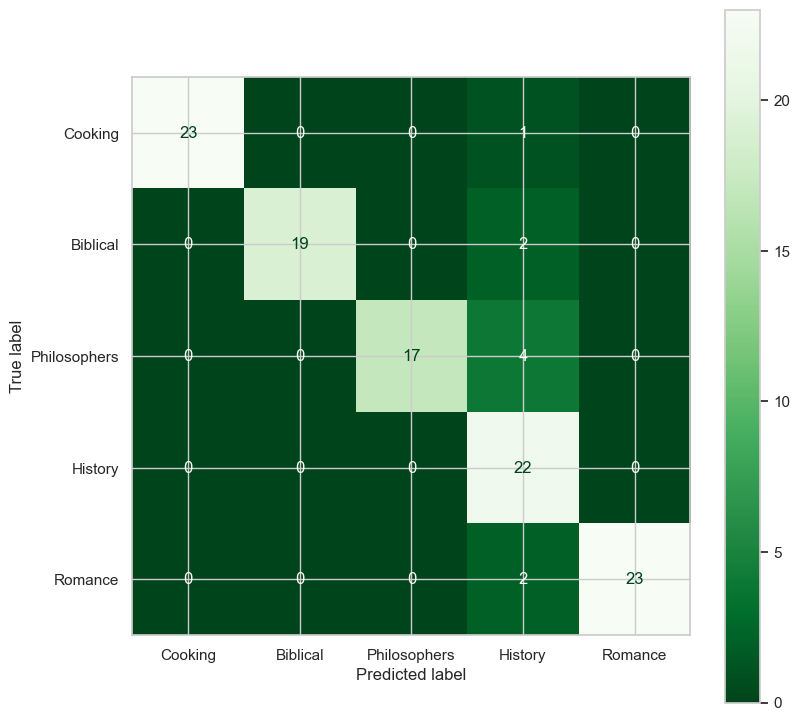

In [71]:
fig, ax = plt.subplots(figsize=(9,9))
cm = confusion_matrix(test_df["label"], predictions0, labels=test_df["label"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_df["label"].unique())
disp.plot(ax=ax, cmap=plt.cm.Greens_r)

From the confusion matrix, it seems the problematic genre is 'History', which was incorrectly predicted for every genre at least once. Biggest mix up was between 'History' and 'Philosophers'

Now let's run Logistic Regression using TextTransformer.


In [72]:
# Logistic 

pipeline1 = Pipeline(
    [
        ("text_preprocessor", TextTransformer()),
        ("cv", CountVectorizer()),
        ("model", LogisticRegression()),
    ]
)

pipeline1.fit(train_df["about"], train_df["label"])

predictions1 = pipeline1.predict(test_df["about"].values)

print("Accuracy: ", accuracy_score(y_true, predictions1))
print("f1_score: ", f1_score(y_true, predictions1, average="weighted"))

Accuracy:  0.9469026548672567
f1_score:  0.9460571039911511


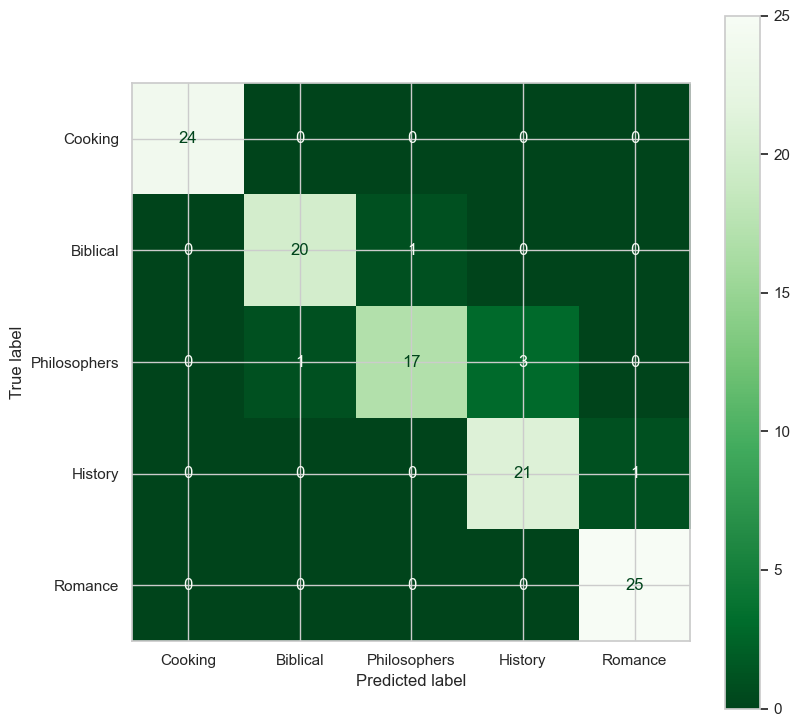

In [73]:
fig, ax = plt.subplots(figsize=(9,9))
cm = confusion_matrix(test_df["label"], predictions1, labels=test_df["label"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_df["label"].unique())
disp.plot(ax=ax, cmap=plt.cm.Greens_r)

We can see that Accuracy and F1 score improved, which might surprising, because we removed the words that had the genre stems in them, but actually makes sense as we also removed some of the most redundant, genre non-descriptive words that were littering all genres.

.

Let's look at top 50 features for each genre.

In [74]:
feature_names = pipeline1.named_steps["cv"].get_feature_names_out()
eli5.explain_weights(pipeline1.named_steps["model"], top=50, feature_names=feature_names)

Explanation(estimator='LogisticRegression()', description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='Biblical', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='christian', weight=0.553645417696009, std=None, value=None), FeatureWeight(feature='god', weight=0.4064546892924865, std=None, value=None), FeatureWeight(feature='church', weight=0.33351014797020856, std=None, value=None), FeatureWeight(feature='jesu', weight=0.3144752071608076, std=None, value=None), FeatureWeight(feature='centuri', weight=0.2941519274417071, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=0.2688138552506682, std=None, value=None), FeatureWeight(feature='testament', weight=0.2509855753137062, std=None, value=None), FeatureWeight(feature='earli', weight=0.25048761334031944, std=None, value=None), FeatureWeight(feature='map', weight=0.24376941519945447, std=None, value=None), FeatureWeight(feature='theolog', weight=0.24059177479297747, std=None, value=None), FeatureWeight(feature='studi', weight=0.23043988762872758, std=None, value=None), FeatureWeight(feature='book', weight=0.22216181188684994, std=None, value=None), FeatureWeight(feature='scriptur', weight=0.2208284299609056, std=None, value=None), FeatureWeight(feature='interpret', weight=0.2206256804602347, std=None, value=None), FeatureWeight(feature='faith', weight=0.21605969253990975, std=None, value=None), FeatureWeight(feature='ancient', weight=0.2106038168791405, std=None, value=None), FeatureWeight(feature='dictionari', weight=0.19227186591707227, std=None, value=None), FeatureWeight(feature='word', weight=0.18843565847643398, std=None, value=None), FeatureWeight(feature='apocryph', weight=0.1868575632040462, std=None, value=None), FeatureWeight(feature='suppress', weight=0.17849432250956299, std=None, value=None), FeatureWeight(feature='courag', weight=0.17575114721038665, std=None, value=None), FeatureWeight(feature='silenc', weight=0.17461109432809352, std=None, value=None), FeatureWeight(feature='ann', weight=0.1743271122522995, std=None, value=None), FeatureWeight(feature='compil', weight=0.1692743780027309, std=None, value=None), FeatureWeight(feature='scholar', weight=0.1677697371579968, std=None, value=None), FeatureWeight(feature='shroud', weight=0.1663941684745033, std=None, value=None), FeatureWeight(feature='song', weight=0.16564242648487756, std=None, value=None), FeatureWeight(feature='understand', weight=0.16486526356690964, std=None, value=None), FeatureWeight(feature='gospel', weight=0.1567196725706846, std=None, value=None), FeatureWeight(feature='catherin', weight=0.15458025401206688, std=None, value=None), FeatureWeight(feature='seven', weight=0.1516966057558118, std=None, value=None), FeatureWeight(feature='featur', weight=0.14281133336571833, std=None, value=None), FeatureWeight(feature='father', weight=0.1410855931775717, std=None, value=None), FeatureWeight(feature='photograph', weight=0.13521619421389608, std=None, value=None), FeatureWeight(feature='includ', weight=0.13418140081363886, std=None, value=None), FeatureWeight(feature='color', weight=0.13189690063132056, std=None, value=None), FeatureWeight(feature='question', weight=0.13183971873296732, std=None, value=None), FeatureWeight(feature='issu', weight=0.1256056603423364, std=None, value=None), FeatureWeight(feature='go', weight=0.1238725084141997, std=None, value=None), FeatureWeight(feature='provid', weight=0.12320629862494892, std=None, val

Let's try a few more models:

In [75]:
# Decision tree performance

pipeline2 = Pipeline(
    [
        ("text_preprocessor", TextTransformer()),
        ("cv", CountVectorizer()),
        ("model", DecisionTreeClassifier()),
    ]
)

pipeline2.fit(train_df["about"], train_df["label"])

y_true = test_df["label"].values

predictions2 = pipeline2.predict(test_df["about"].values)

print("Accuracy: ", accuracy_score(y_true, predictions2))
print("f1_score: ", f1_score(y_true, predictions2, average="weighted"))

Accuracy:  0.7876106194690266
f1_score:  0.7832253058548887


In [76]:
# Random forrest performance

pipeline3 = Pipeline(
    [
        ("text_preprocessor", TextTransformer()),
        ("cv", CountVectorizer()),
        ("model", RandomForestClassifier()),
    ]
)

pipeline3.fit(train_df["about"], train_df["label"])

predictions3 = pipeline3.predict(test_df["about"].values)

print("Accuracy: ", accuracy_score(y_true, predictions3))
print("f1_score: ", f1_score(y_true, predictions3, average="weighted"))

Accuracy:  0.9380530973451328
f1_score:  0.9364178531279208


### Hyperparameter Tuning

Model Hyperparameters are the properties that govern the entire training process. Hyperparameters are important because they directly control the behaviour of the training algorithm and have a significant impact on the performance of the model is being trained. Hyperparameter tuning tests different hyperparameter configurations when training a model. It can give optimized values for hyperparameters, which maximizes the model's predictive accuracy.


Logistic Regression and Decision Trees gave the the best results - I'll try hyperparam tuning on these two models

In [77]:
def extract_best_model_params(params: Dict[str, Any]):
    filtered_dict = {}
    for key, value in params.items():
        if "model__" in key:
            filtered_dict[key.split("model__")[-1]] = value
    return filtered_dict

Logistic regression performance with hyperparam tuning:

In [78]:

params = {
    "model__solver": ["newton-cg", "lbfgs", "liblinear"],
    "model__C": [100, 10, 1.0, 0.1, 0.01],
    "model__max_iter": randint(1000, 10000),
}

pipeline = Pipeline(
    [
        ("text_preprocessor", TextTransformer()),
        ("cv", CountVectorizer()),
        ("model", LogisticRegression()),
    ]
)

search = RandomizedSearchCV(pipeline, params, n_iter=100, cv=5, random_state=14)
search.fit(train_df["about"], train_df["label"])

pipeline = Pipeline(
    [
        ("text_preprocessor", TextTransformer()),
        ("cv", CountVectorizer()),
        (
            "model",
            LogisticRegression(**extract_best_model_params(search.best_estimator_.get_params())),
        ),
    ]
)

pipeline.fit(train_df["about"], train_df["label"])

predictions = pipeline.predict(test_df["about"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print("f1_score: ", f1_score(y_true, predictions, average="weighted"))
print(classification_report(y_true, predictions))

Accuracy:  0.9646017699115044
f1_score:  0.9643647659797785
              precision    recall  f1-score   support

    Biblical       0.95      0.95      0.95        21
     Cooking       1.00      1.00      1.00        24
     History       0.95      0.95      0.95        22
Philosophers       0.95      0.90      0.93        21
     Romance       0.96      1.00      0.98        25

    accuracy                           0.96       113
   macro avg       0.96      0.96      0.96       113
weighted avg       0.96      0.96      0.96       113



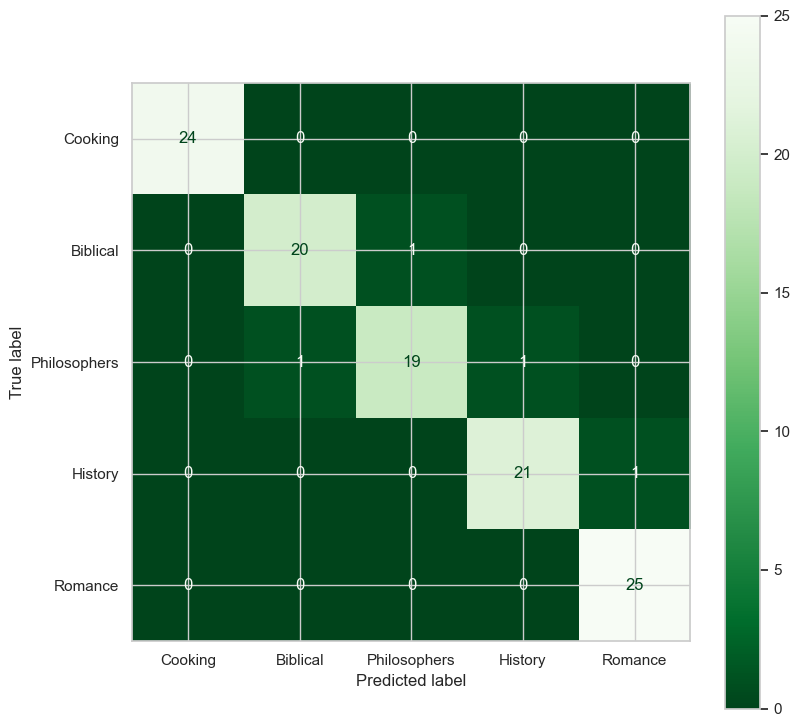

In [79]:
fig, ax = plt.subplots(figsize=(9,9))
cm = confusion_matrix(test_df["label"], predictions, labels=test_df["label"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_df["label"].unique())
disp.plot(ax=ax, cmap=plt.cm.Greens_r)

With hyperparameter tuning, the model is now able to distinguish between 'History' and 'Philosophers' books just as well as other genres.

Random forrest performance with hyperparam tuning:

In [160]:
params = {
    "model__n_estimators": randint(5, 500),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_depth": randint(100, 200)
}

pipeline5 = Pipeline(
    [
        ("text_preprocessor", TextTransformer()),
        ("cv", CountVectorizer()),
        ("model", RandomForestClassifier()),
    ]
)

search = RandomizedSearchCV(pipeline5, params, n_iter=100, cv=5, random_state=14)
search.fit(train_df["about"], train_df["label"])

pipeline5 = Pipeline(
    [
        ("text_preprocessor", TextTransformer()),
        ("cv", CountVectorizer()),
        (
            "model",
            RandomForestClassifier(**extract_best_model_params(search.best_estimator_.get_params())),
        ),
    ]
)

pipeline5.fit(train_df["about"], train_df["label"])

predictions5 = pipeline5.predict(test_df["about"].values)

print("Accuracy: ", accuracy_score(y_true, predictions5))
print("f1_score: ", f1_score(y_true, predictions5, average="weighted"))
print(classification_report(y_true, predictions5))

Accuracy:  0.9380530973451328
f1_score:  0.9351442610748563
              precision    recall  f1-score   support

    Biblical       0.88      1.00      0.93        21
     Cooking       1.00      0.96      0.98        24
     History       0.92      1.00      0.96        22
Philosophers       1.00      0.71      0.83        21
     Romance       0.93      1.00      0.96        25

    accuracy                           0.94       113
   macro avg       0.94      0.93      0.93       113
weighted avg       0.94      0.94      0.94       113



From the above, it is evident that ater hyperparameter tuning, Logistic Regression is performing the best. Let's export the model:

In [81]:
cloudpickle.dump(pipeline, open("D:/CA_AI_2022/midterm/book_model.pkl", "wb"))

In [82]:
book_model = cloudpickle.load(open("D:/CA_AI_2022/midterm/book_model.pkl", "rb"))

This is how the final model pipeline looks like:

In [83]:
book_model

Pipeline(steps=[('text_preprocessor', TextTransformer()),
                ('cv', CountVectorizer()),
                ('model',
                 LogisticRegression(C=0.01, max_iter=4593,
                                    solver='liblinear'))])